In [1]:
# importing all necessary libraries to run the code
import re,string
import numpy as np
import pandas as pd
import keras_metrics
import tensorflow.keras
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation,Embedding,GlobalMaxPooling1D
# using the variable sw to hold all stopwords that are in English
sw = stopwords.words('english')

C:\Users\Mobeen Shahroz\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
#reading dataset
data=pd.read_csv('train.csv')

In [2]:
from tqdm import tqdm
import os, re, csv, math, codecs
#load embeddings
print('loading word embeddings...')
embeddings_index = {}
f = codecs.open('crawl-300d-2M.vec', encoding='utf-8')
for line in tqdm(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('found %s word vectors' % len(embeddings_index))

loading word embeddings...


1999996it [08:19, 4001.86it/s]


found 1999996 word vectors


In [24]:
MAX_NB_WORDS = 100000
embed_dim = 300 
max_seq_len =94
#training params
batch_size = 256 
num_epochs = 8 

#model parameters
num_filters = 64 
embed_dim = 300 
weight_decay = 1e-4

In [6]:
#checking dataset values type
data.head(2)

,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again."
0,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
1,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...


In [7]:
data.columns=['Target','Headline','HeadlineBody']
data.head(2)

,Target,Headline,HeadlineBody
0,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
1,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...


In [8]:
data['text']= data['Headline']+ ' '+data['HeadlineBody']
#data['text']

In [9]:
#applying pre-processing steps to remove stopwords and words of size less than 2
data['text'] = data['text'].apply(lambda x: x.split())
wordsEng = stopwords.words('english')
data['text'] = data['text'].apply(lambda x:[item for item in x if item not in wordsEng])
data['text'] = data['text'].apply(lambda x: [w for w in x if len(w)>2])
data['text'] = data['text'].apply(lambda x: " ".join(x))
data.head(2)

,Target,Headline,HeadlineBody,text
0,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...,Carlyle Looks Toward Commercial Aerospace (Reu...
1,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...,Oil Economy Cloud Stocks' Outlook (Reuters) Re...


In [10]:
#removing airline company names as pre-processing
testList=[]
def strip_links(text):
    link_regex    = re.compile('((https?):((//)|(\\\\))+([\w\d:#@%/;$()~_?\+-=\\\.&](#!)?)*)', re.DOTALL)
    links         = re.findall(link_regex, text)
    for link in links:
        text = text.replace(link[0], ', ')    
    return text

def strip_all_entities(text):
    entity_prefixes = ['@','#']
    for separator in  string.punctuation:
        if separator not in entity_prefixes :
            text = text.replace(separator,' ')
    words = []
    for word in text.split():
        word = word.strip()
        if word:
            if word[0] not in entity_prefixes:
                words.append(word)
    return ' '.join(words)


for t in range(len(data)):
    testList.append(strip_all_entities(strip_links(data['text'][t])))

In [11]:
#converting testList[] list into dataframe for further processing
dat = pd.DataFrame(np.array(testList))
dat.head(2)

,0
0,Carlyle Looks Toward Commercial Aerospace Reut...
1,Oil Economy Cloud Stocks Outlook Reuters Reute...


In [12]:
# applying pre-processing to remove special symbols, numbers and converting into lower case
sw = stopwords.words('english')
twitterSentiment=[]
for i in range(len(dat)):
    review = re.sub('[^a-zA-Z]', ' ',dat[0][i])
    review = re.sub('[/(){}\[\]\|@!,;]', ' ',dat[0][i])
    review = re.sub('[^0-9a-zA-Z #+_♥️]', ' ',dat[0][i])#Remove bad symbols
    
    review = re.sub(r'\d+', '',review)
    review = review.lower()
    review = review.split()

    review = [token for token in review if token not in sw]
    review=' '.join(review)
    review=' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",review).split())
    twitterSentiment.append(review)

In [13]:
#converting twitterSentiment[] list into dataframe for serving it to keras tokenizer
dataSetFinal = pd.DataFrame(np.array(twitterSentiment))
dataSetFinal.head(5)

,0
0,carlyle looks toward commercial aerospace reut...
1,oil economy cloud stocks outlook reuters reute...
2,iraq halts oil exports main southern pipeline ...
3,oil prices soar time record posing new menace ...
4,stocks end near year lows reuters reuters stoc...


In [15]:
tokenizer = tensorflow.keras.preprocessing.text.Tokenizer(num_words=7500, lower=True,split=' ',filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(dataSetFinal[0].values)
#print(tokenizer.word_index)  # To see the dicstionary
X = tokenizer.texts_to_sequences(dataSetFinal[0].values)
X = tensorflow.keras.preprocessing.sequence.pad_sequences(X)
word_index = tokenizer.word_index
print("dictionary size: ", len(word_index))

dictionary size:  61605


In [25]:
#embedding matrix
print('preparing embedding matrix...')
words_not_found = []
nb_words = min(MAX_NB_WORDS, len(word_index))
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 11673


In [26]:
from keras import regularizers
from keras import optimizers
from keras import backend as K
print("training CNN ...")
model = Sequential()
model.add(Embedding(nb_words, embed_dim,
          weights=[embedding_matrix], input_length=max_seq_len, trainable=False))
model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model.add(MaxPooling1D(2))
model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Dense(4, activation='softmax'))  #multi-label (k-hot encoding)

adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy','mae',keras_metrics.precision(), keras_metrics.recall()])
model.summary()

training CNN ...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 94, 300)           18481500  
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 94, 64)            134464    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 47, 64)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 47, 64)            28736     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 64)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080

In [18]:
#define callbacks
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=4, verbose=1)
callbacks_list = [early_stopping]

In [27]:
#batch_size=64
Y = pd.get_dummies(data['Target']).values
X_train, X_valid, Y_train, Y_valid = train_test_split(X,Y, test_size = 0.30)
#Here we train the Network.
#pred=model_conv.fit(X_train, Y_train, batch_size =batch_size, epochs =100, verbose =2,validation_data=(X_valid,Y_valid))
#pred

#model training
hist = model.fit(X_train, Y_train, batch_size=batch_size, epochs=num_epochs, callbacks=callbacks_list, validation_split=0.1, shuffle=True, verbose=2)
hist

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 75599 samples, validate on 8400 samples
Epoch 1/8
 - 84s - loss: 0.2023 - acc: 0.9269 - mean_absolute_error: 0.1168 - precision: 0.9175 - recall: 0.7906 - val_loss: 0.1461 - val_acc: 0.9496 - val_mean_absolute_error: 0.0761 - val_precision: 0.9408 - val_recall: 0.8634
Epoch 2/8
 - 83s - loss: 0.1501 - acc: 0.9495 - mean_absolute_error: 0.0828 - precision: 0.9339 - recall: 0.8645 - val_loss: 0.1351 - val_acc: 0.9513 - val_mean_absolute_error: 0.0738 - val_precision: 0.9482 - val_recall: 0.8644
Epoch 3/8
 - 84s - loss: 0.1329 - acc: 0.9548 - mean_absolute_error: 0.0736 - precision: 0.9426 - recall: 0.8744 - val_loss: 0.1295 - val_acc: 0.9552 - val_mean_absolute_error: 0.0688 - val_precision: 0.9609 - val_recall: 0.8587
Epoch 4/8
 - 84s - loss: 0.1154 - acc: 0.9607 - mean_absolute_error: 0.0642 - precision: 0.9505 - recall: 0.8914 - val_loss: 0.1256 - val_

In [28]:
score=[]
score=model.evaluate(X_valid,Y_valid,verbose=2,batch_size=batch_size)
#keras.metrics.binary_accuracy(Y_valid,pred)
print("score: %.2f" %(score[0]))
print("validation accuracy: %.2f" % (score[1]))
print("recall: %.2f" %(score[4]))
print("Precision: %.2f" % (score[3]))

score: 0.14
validation accuracy: 0.95
recall: 0.88
Precision: 0.94


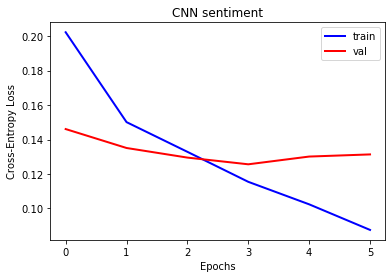

In [29]:
#generate plots
plt.figure()
plt.plot(hist.history['loss'], lw=2.0, color='b', label='train')
plt.plot(hist.history['val_loss'], lw=2.0, color='r', label='val')
plt.title('CNN sentiment')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend(loc='upper right')
plt.savefig('training & validation LossAGNews.pdf')
plt.show()

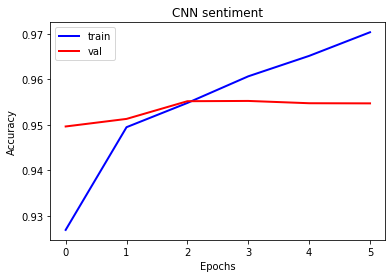

In [30]:
plt.figure()
plt.plot(hist.history['acc'], lw=2.0, color='b', label='train')
plt.plot(hist.history['val_acc'], lw=2.0, color='r', label='val')
plt.title('CNN sentiment')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.savefig('training & validation accuracyAGNews.pdf')
plt.show()

In [66]:
from keras import optimizers
#Deep Learning Network Structure
model_conv = Sequential()
model_conv.add(Embedding(7500, 300, input_length=X.shape[1]))
model_conv.add(Dropout(0.2))
model_conv.add(Conv1D(64, 5, activation='relu'))
model_conv.add(MaxPooling1D(pool_size=4))
model_conv.add(LSTM(100))
model_conv.add(Dense(3, activation='softmax'))
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model_conv.compile(loss='binary_crossentropy', optimizer='sgd',metrics=['accuracy','mae',keras_metrics.precision(), keras_metrics.recall()])

In [41]:
batch_size=64
Y = pd.get_dummies(data['airline_sentiment']).values
X_train, X_valid, Y_train, Y_valid = train_test_split(X,Y, test_size = 0.30)
#Here we train the Network.
pred=model_conv.fit(X_train, Y_train, batch_size =batch_size, epochs =100, verbose =2,validation_data=(X_valid,Y_valid))
pred

Train on 10248 samples, validate on 4392 samples
Epoch 1/100
 - 15s - loss: 0.5936 - acc: 0.6667 - mean_absolute_error: 0.4207 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.5660 - val_acc: 0.6667 - val_mean_absolute_error: 0.4027 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
 - 13s - loss: 0.5527 - acc: 0.7374 - mean_absolute_error: 0.3867 - precision: 0.6235 - recall: 0.8567 - val_loss: 0.5449 - val_acc: 0.7532 - val_mean_absolute_error: 0.3797 - val_precision: 0.6298 - val_recall: 1.0000
Epoch 3/100
 - 13s - loss: 0.5430 - acc: 0.7505 - mean_absolute_error: 0.3704 - precision: 0.6257 - recall: 1.0000 - val_loss: 0.5389 - val_acc: 0.7532 - val_mean_absolute_error: 0.3695 - val_precision: 0.6298 - val_recall: 1.0000
Epoch 4/100
 - 13s - loss: 0.5405 - acc: 0.7505 - mean_absolute_error: 0.3628 - precision: 0.6257 - recall: 1.0000 - val_loss: 0.5369 - val_acc: 0.7532 - val_mean_absolute_error: 0.3665 - val_precision: 0.6298 - val_recall: 1.0000
Epoch 5/100

Epoch 37/100
 - 13s - loss: 0.5043 - acc: 0.7744 - mean_absolute_error: 0.3328 - precision: 0.7138 - recall: 0.8621 - val_loss: 0.5006 - val_acc: 0.7741 - val_mean_absolute_error: 0.3368 - val_precision: 0.7184 - val_recall: 0.8420
Epoch 38/100
 - 13s - loss: 0.5043 - acc: 0.7744 - mean_absolute_error: 0.3323 - precision: 0.7151 - recall: 0.8584 - val_loss: 0.4999 - val_acc: 0.7747 - val_mean_absolute_error: 0.3350 - val_precision: 0.7181 - val_recall: 0.8474
Epoch 39/100
 - 13s - loss: 0.5039 - acc: 0.7740 - mean_absolute_error: 0.3317 - precision: 0.7163 - recall: 0.8520 - val_loss: 0.4995 - val_acc: 0.7751 - val_mean_absolute_error: 0.3337 - val_precision: 0.7179 - val_recall: 0.8510
Epoch 40/100
 - 13s - loss: 0.5036 - acc: 0.7747 - mean_absolute_error: 0.3305 - precision: 0.7156 - recall: 0.8596 - val_loss: 0.4992 - val_acc: 0.7746 - val_mean_absolute_error: 0.3339 - val_precision: 0.7186 - val_recall: 0.8449
Epoch 41/100
 - 14s - loss: 0.5035 - acc: 0.7737 - mean_absolute_error: 

Epoch 73/100
 - 13s - loss: 0.4962 - acc: 0.7756 - mean_absolute_error: 0.3238 - precision: 0.7212 - recall: 0.8517 - val_loss: 0.4921 - val_acc: 0.7769 - val_mean_absolute_error: 0.3295 - val_precision: 0.7249 - val_recall: 0.8467
Epoch 74/100
 - 15s - loss: 0.4960 - acc: 0.7761 - mean_absolute_error: 0.3243 - precision: 0.7233 - recall: 0.8500 - val_loss: 0.4918 - val_acc: 0.7772 - val_mean_absolute_error: 0.3292 - val_precision: 0.7255 - val_recall: 0.8474
Epoch 75/100
 - 14s - loss: 0.4956 - acc: 0.7757 - mean_absolute_error: 0.3248 - precision: 0.7240 - recall: 0.8450 - val_loss: 0.4912 - val_acc: 0.7769 - val_mean_absolute_error: 0.3273 - val_precision: 0.7231 - val_recall: 0.8507
Epoch 76/100
 - 14s - loss: 0.4954 - acc: 0.7762 - mean_absolute_error: 0.3238 - precision: 0.7236 - recall: 0.8495 - val_loss: 0.4910 - val_acc: 0.7772 - val_mean_absolute_error: 0.3277 - val_precision: 0.7242 - val_recall: 0.8507
Epoch 77/100
 - 15s - loss: 0.4950 - acc: 0.7755 - mean_absolute_error: 

In [46]:
score=[]
score=model_conv.evaluate(X_valid,Y_valid,verbose=2,batch_size=batch_size)
#keras.metrics.binary_accuracy(Y_valid,pred)
print("score: %.2f" %(score[0]))
print("validation accuracy: %.2f" % (score[1]))
print("recall: %.2f" %(score[4]))
print("Precision: %.2f" % (score[3]))

score: 0.48
validation accuracy: 0.78
recall: 0.85
Precision: 0.74


In [48]:
batch_size=64
Y = pd.get_dummies(data['airline_sentiment']).values
X_train, X_valid, Y_train, Y_valid = train_test_split(X,Y, test_size = 0.25)
#Here we train the Network.
pred=model_conv.fit(X_train, Y_train, batch_size =batch_size, epochs =100, verbose =2,validation_data=(X_valid,Y_valid))
pred

Train on 10980 samples, validate on 3660 samples
Epoch 1/100
 - 17s - loss: 0.5839 - acc: 0.6737 - mean_absolute_error: 0.4139 - precision: 0.5881 - recall: 0.1117 - val_loss: 0.5633 - val_acc: 0.6852 - val_mean_absolute_error: 0.3976 - val_precision: 0.7525 - val_recall: 0.1351
Epoch 2/100
 - 15s - loss: 0.5453 - acc: 0.7540 - mean_absolute_error: 0.3777 - precision: 0.6310 - recall: 1.0000 - val_loss: 0.5492 - val_acc: 0.7432 - val_mean_absolute_error: 0.3772 - val_precision: 0.6148 - val_recall: 1.0000
Epoch 3/100
 - 15s - loss: 0.5387 - acc: 0.7540 - mean_absolute_error: 0.3635 - precision: 0.6310 - recall: 1.0000 - val_loss: 0.5461 - val_acc: 0.7432 - val_mean_absolute_error: 0.3701 - val_precision: 0.6148 - val_recall: 1.0000
Epoch 4/100
 - 15s - loss: 0.5367 - acc: 0.7540 - mean_absolute_error: 0.3582 - precision: 0.6310 - recall: 1.0000 - val_loss: 0.5446 - val_acc: 0.7432 - val_mean_absolute_error: 0.3679 - val_precision: 0.6148 - val_recall: 1.0000
Epoch 5/100
 - 15s - loss: 

Epoch 37/100
 - 15s - loss: 0.4989 - acc: 0.7769 - mean_absolute_error: 0.3273 - precision: 0.7193 - recall: 0.8594 - val_loss: 0.5094 - val_acc: 0.7683 - val_mean_absolute_error: 0.3361 - val_precision: 0.7053 - val_recall: 0.8520
Epoch 38/100
 - 15s - loss: 0.4988 - acc: 0.7767 - mean_absolute_error: 0.3265 - precision: 0.7195 - recall: 0.8570 - val_loss: 0.5091 - val_acc: 0.7679 - val_mean_absolute_error: 0.3360 - val_precision: 0.7056 - val_recall: 0.8480
Epoch 39/100
 - 15s - loss: 0.4984 - acc: 0.7768 - mean_absolute_error: 0.3262 - precision: 0.7205 - recall: 0.8558 - val_loss: 0.5088 - val_acc: 0.7679 - val_mean_absolute_error: 0.3360 - val_precision: 0.7060 - val_recall: 0.8462
Epoch 40/100
 - 15s - loss: 0.4983 - acc: 0.7767 - mean_absolute_error: 0.3262 - precision: 0.7217 - recall: 0.8519 - val_loss: 0.5086 - val_acc: 0.7680 - val_mean_absolute_error: 0.3351 - val_precision: 0.7060 - val_recall: 0.8476
Epoch 41/100
 - 15s - loss: 0.4981 - acc: 0.7767 - mean_absolute_error: 

Epoch 73/100
 - 15s - loss: 0.4893 - acc: 0.7793 - mean_absolute_error: 0.3203 - precision: 0.7279 - recall: 0.8549 - val_loss: 0.4994 - val_acc: 0.7714 - val_mean_absolute_error: 0.3309 - val_precision: 0.7157 - val_recall: 0.8480
Epoch 74/100
 - 15s - loss: 0.4891 - acc: 0.7793 - mean_absolute_error: 0.3198 - precision: 0.7275 - recall: 0.8565 - val_loss: 0.4990 - val_acc: 0.7719 - val_mean_absolute_error: 0.3314 - val_precision: 0.7178 - val_recall: 0.8458
Epoch 75/100
 - 15s - loss: 0.4886 - acc: 0.7800 - mean_absolute_error: 0.3200 - precision: 0.7296 - recall: 0.8562 - val_loss: 0.4985 - val_acc: 0.7717 - val_mean_absolute_error: 0.3300 - val_precision: 0.7158 - val_recall: 0.8498
Epoch 76/100
 - 15s - loss: 0.4878 - acc: 0.7800 - mean_absolute_error: 0.3188 - precision: 0.7278 - recall: 0.8606 - val_loss: 0.4981 - val_acc: 0.7723 - val_mean_absolute_error: 0.3312 - val_precision: 0.7194 - val_recall: 0.8453
Epoch 77/100
 - 15s - loss: 0.4872 - acc: 0.7796 - mean_absolute_error: 

In [52]:
batch_size=32
Y = pd.get_dummies(data['airline_sentiment']).values
X_train, X_valid, Y_train, Y_valid = train_test_split(X,Y, test_size = 0.25)
#Here we train the Network.
pred=model_conv.fit(X_train, Y_train, batch_size =batch_size, epochs =100, verbose =2,validation_data=(X_valid,Y_valid))
pred

Train on 10980 samples, validate on 3660 samples
Epoch 1/100
 - 12s - loss: 0.5707 - acc: 0.7067 - mean_absolute_error: 0.4013 - precision: 0.6254 - recall: 0.4795 - val_loss: 0.5411 - val_acc: 0.7552 - val_mean_absolute_error: 0.3727 - val_precision: 0.6328 - val_recall: 1.0000
Epoch 2/100
 - 10s - loss: 0.5425 - acc: 0.7500 - mean_absolute_error: 0.3659 - precision: 0.6250 - recall: 1.0000 - val_loss: 0.5350 - val_acc: 0.7552 - val_mean_absolute_error: 0.3622 - val_precision: 0.6328 - val_recall: 1.0000
Epoch 3/100
 - 10s - loss: 0.5390 - acc: 0.7500 - mean_absolute_error: 0.3607 - precision: 0.6250 - recall: 1.0000 - val_loss: 0.5319 - val_acc: 0.7552 - val_mean_absolute_error: 0.3581 - val_precision: 0.6328 - val_recall: 1.0000
Epoch 4/100
 - 10s - loss: 0.5365 - acc: 0.7500 - mean_absolute_error: 0.3583 - precision: 0.6250 - recall: 1.0000 - val_loss: 0.5294 - val_acc: 0.7552 - val_mean_absolute_error: 0.3551 - val_precision: 0.6328 - val_recall: 1.0000
Epoch 5/100
 - 10s - loss: 

Epoch 37/100
 - 12s - loss: 0.4968 - acc: 0.7754 - mean_absolute_error: 0.3251 - precision: 0.7206 - recall: 0.8525 - val_loss: 0.4863 - val_acc: 0.7810 - val_mean_absolute_error: 0.3214 - val_precision: 0.7306 - val_recall: 0.8584
Epoch 38/100
 - 11s - loss: 0.4961 - acc: 0.7744 - mean_absolute_error: 0.3254 - precision: 0.7213 - recall: 0.8429 - val_loss: 0.4859 - val_acc: 0.7812 - val_mean_absolute_error: 0.3166 - val_precision: 0.7209 - val_recall: 0.8864
Epoch 39/100
 - 10s - loss: 0.4954 - acc: 0.7754 - mean_absolute_error: 0.3243 - precision: 0.7212 - recall: 0.8509 - val_loss: 0.4851 - val_acc: 0.7820 - val_mean_absolute_error: 0.3163 - val_precision: 0.7227 - val_recall: 0.8869
Epoch 40/100
 - 10s - loss: 0.4945 - acc: 0.7750 - mean_absolute_error: 0.3236 - precision: 0.7186 - recall: 0.8550 - val_loss: 0.4840 - val_acc: 0.7818 - val_mean_absolute_error: 0.3193 - val_precision: 0.7298 - val_recall: 0.8666
Epoch 41/100
 - 11s - loss: 0.4935 - acc: 0.7763 - mean_absolute_error: 

Epoch 73/100
 - 13s - loss: 0.4149 - acc: 0.8076 - mean_absolute_error: 0.2791 - precision: 0.8230 - recall: 0.8620 - val_loss: 0.4158 - val_acc: 0.8095 - val_mean_absolute_error: 0.2738 - val_precision: 0.8101 - val_recall: 0.8843
Epoch 74/100
 - 12s - loss: 0.4123 - acc: 0.8086 - mean_absolute_error: 0.2767 - precision: 0.8239 - recall: 0.8664 - val_loss: 0.4149 - val_acc: 0.8088 - val_mean_absolute_error: 0.2715 - val_precision: 0.8062 - val_recall: 0.8873
Epoch 75/100
 - 11s - loss: 0.4096 - acc: 0.8092 - mean_absolute_error: 0.2752 - precision: 0.8277 - recall: 0.8643 - val_loss: 0.4129 - val_acc: 0.8094 - val_mean_absolute_error: 0.2710 - val_precision: 0.8133 - val_recall: 0.8782
Epoch 76/100
 - 10s - loss: 0.4078 - acc: 0.8098 - mean_absolute_error: 0.2735 - precision: 0.8293 - recall: 0.8651 - val_loss: 0.4116 - val_acc: 0.8099 - val_mean_absolute_error: 0.2757 - val_precision: 0.8363 - val_recall: 0.8446
Epoch 77/100
 - 10s - loss: 0.4044 - acc: 0.8111 - mean_absolute_error: 

In [56]:
Results=[]
Results=model_conv.evaluate(X_valid,Y_valid,verbose=2,batch_size=batch_size)
#keras.metrics.binary_accuracy(Y_valid,pred)
print("validation accuracy: %.2f" % (Results[1]))
print("validation Recall: %.2f" %(Results[4]))
print("validation Precision: %.2f" % (Results[3]))
print("validation Mean Absolute Eror: %.2f" % (Results[2]))

validation accuracy: 0.82
validation Recall: 0.89
validation Precision: 0.81
validation Mean Absolute Eror: 0.24


In [67]:
batch_size=32
Y = pd.get_dummies(data['airline_sentiment']).values
X_train, X_valid, Y_train, Y_valid = train_test_split(X,Y, test_size = 0.25)
#Here we train the Network.
pred=model_conv.fit(X_train, Y_train, batch_size =batch_size, epochs =100, verbose =2,validation_data=(X_valid,Y_valid))
pred

Train on 10980 samples, validate on 3660 samples
Epoch 1/100
 - 15s - loss: 0.5743 - acc: 0.6987 - mean_absolute_error: 0.4050 - precision: 0.6185 - recall: 0.4006 - val_loss: 0.5462 - val_acc: 0.7519 - val_mean_absolute_error: 0.3796 - val_precision: 0.6279 - val_recall: 1.0000
Epoch 2/100
 - 13s - loss: 0.5420 - acc: 0.7511 - mean_absolute_error: 0.3683 - precision: 0.6266 - recall: 1.0000 - val_loss: 0.5388 - val_acc: 0.7519 - val_mean_absolute_error: 0.3641 - val_precision: 0.6279 - val_recall: 1.0000
Epoch 3/100
 - 13s - loss: 0.5386 - acc: 0.7511 - mean_absolute_error: 0.3603 - precision: 0.6266 - recall: 1.0000 - val_loss: 0.5365 - val_acc: 0.7519 - val_mean_absolute_error: 0.3600 - val_precision: 0.6279 - val_recall: 1.0000
Epoch 4/100
 - 14s - loss: 0.5365 - acc: 0.7511 - mean_absolute_error: 0.3578 - precision: 0.6266 - recall: 1.0000 - val_loss: 0.5346 - val_acc: 0.7519 - val_mean_absolute_error: 0.3581 - val_precision: 0.6279 - val_recall: 1.0000
Epoch 5/100
 - 21s - loss: 

Epoch 37/100
 - 12s - loss: 0.4988 - acc: 0.7735 - mean_absolute_error: 0.3255 - precision: 0.7186 - recall: 0.8410 - val_loss: 0.4998 - val_acc: 0.7755 - val_mean_absolute_error: 0.3298 - val_precision: 0.7224 - val_recall: 0.8446
Epoch 38/100
 - 12s - loss: 0.4985 - acc: 0.7741 - mean_absolute_error: 0.3261 - precision: 0.7195 - recall: 0.8427 - val_loss: 0.4994 - val_acc: 0.7755 - val_mean_absolute_error: 0.3295 - val_precision: 0.7224 - val_recall: 0.8446
Epoch 39/100
 - 12s - loss: 0.4982 - acc: 0.7735 - mean_absolute_error: 0.3264 - precision: 0.7191 - recall: 0.8392 - val_loss: 0.4988 - val_acc: 0.7761 - val_mean_absolute_error: 0.3264 - val_precision: 0.7219 - val_recall: 0.8507
Epoch 40/100
 - 12s - loss: 0.4977 - acc: 0.7741 - mean_absolute_error: 0.3256 - precision: 0.7199 - recall: 0.8417 - val_loss: 0.4984 - val_acc: 0.7766 - val_mean_absolute_error: 0.3252 - val_precision: 0.7216 - val_recall: 0.8551
Epoch 41/100
 - 12s - loss: 0.4971 - acc: 0.7742 - mean_absolute_error: 

Epoch 73/100
 - 16s - loss: 0.4444 - acc: 0.7922 - mean_absolute_error: 0.2980 - precision: 0.7641 - recall: 0.8695 - val_loss: 0.4533 - val_acc: 0.7934 - val_mean_absolute_error: 0.3086 - val_precision: 0.7888 - val_recall: 0.8272
Epoch 74/100
 - 19s - loss: 0.4419 - acc: 0.7933 - mean_absolute_error: 0.2970 - precision: 0.7696 - recall: 0.8654 - val_loss: 0.4497 - val_acc: 0.7937 - val_mean_absolute_error: 0.3008 - val_precision: 0.7751 - val_recall: 0.8551
Epoch 75/100
 - 14s - loss: 0.4392 - acc: 0.7944 - mean_absolute_error: 0.2948 - precision: 0.7730 - recall: 0.8660 - val_loss: 0.4477 - val_acc: 0.7931 - val_mean_absolute_error: 0.2958 - val_precision: 0.7653 - val_recall: 0.8712
Epoch 76/100
 - 18s - loss: 0.4361 - acc: 0.7952 - mean_absolute_error: 0.2928 - precision: 0.7772 - recall: 0.8625 - val_loss: 0.4458 - val_acc: 0.7956 - val_mean_absolute_error: 0.2980 - val_precision: 0.7830 - val_recall: 0.8525
Epoch 77/100
 - 17s - loss: 0.4338 - acc: 0.7970 - mean_absolute_error: 

In [68]:
ResultFinal=[]
ResultFinal=model_conv.evaluate(X_valid,Y_valid,verbose=2,batch_size=batch_size)
#keras.metrics.binary_accuracy(Y_valid,pred)
print("validation accuracy: %.2f" % (ResultFinal[1]))
print("validation Recall: %.2f" %(ResultFinal[4]))
print("validation Precision: %.2f" % (ResultFinal[3]))
print("validation Mean Absolute Eror: %.2f" % (ResultFinal[2]))

validation accuracy: 0.80
validation Recall: 0.70
validation Precision: 0.88
validation Mean Absolute Eror: 0.30


In [57]:
import pickle
pickle.dump(model_conv,open('LSTMModel.csv','wb'))
pickle.dump(model_conv,open('LSTMModel.sav','wb'))
pickle.dump(model_conv,open('CNNModel.csv','wb'))
pickle.dump(model_conv,open('CNNModel.sav','wb'))

In [58]:
import pickle
pickle.dump(X_train,open('X_train.csv','wb'))
pickle.dump(X_train,open('X_train.sav','wb'))
pickle.dump(X_valid,open('X_valid.sav','wb'))
pickle.dump(X_valid,open('X_valid.csv','wb'))
pickle.dump(Y_train,open('Y_train.csv','wb'))
pickle.dump(Y_train,open('Y_train.sav','wb'))
pickle.dump(Y_valid,open('Y_valid.sav','wb'))
pickle.dump(Y_valid,open('Y_valid.csv','wb'))
pickle.dump(tokenizer,open('tokenizer.sav','wb'))
pickle.dump(tokenizer,open('tokenizer.csv','wb'))

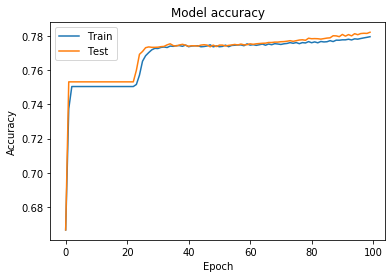

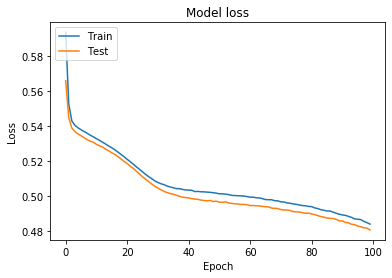

In [42]:
import matplotlib.pyplot as plt
# Plot training & validation accuracy values
plt.plot(pred.history['acc'])
plt.plot(pred.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('training & validation accuracy2.pdf')
plt.show()


# Plot training & validation loss values
plt.plot(pred.history['loss'])
plt.plot(pred.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('training & validation loss2.pdf')
plt.show()


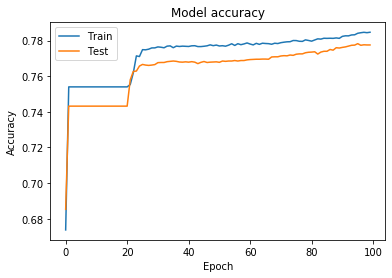

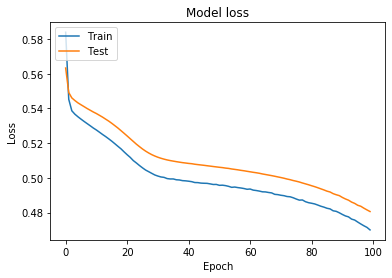

In [49]:
import matplotlib.pyplot as plt
# Plot training & validation accuracy values
plt.plot(pred.history['acc'])
plt.plot(pred.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('training & validation accuracy3.pdf')
plt.show()


# Plot training & validation loss values
plt.plot(pred.history['loss'])
plt.plot(pred.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('training & validation loss3.pdf')
plt.show()


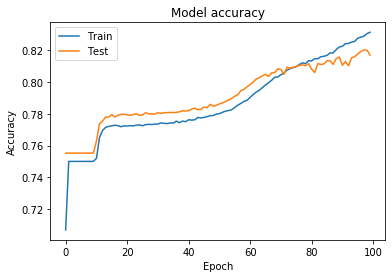

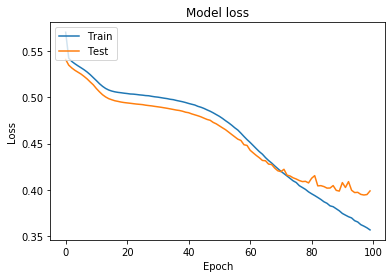

In [53]:
import matplotlib.pyplot as plt
# Plot training & validation accuracy values
plt.plot(pred.history['acc'])
plt.plot(pred.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('training & validation accuracyFinal.pdf')
plt.show()


# Plot training & validation loss values
plt.plot(pred.history['loss'])
plt.plot(pred.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('training & validation lossFinal.pdf')
plt.show()


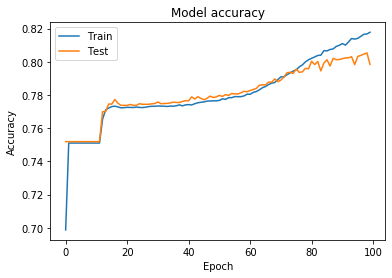

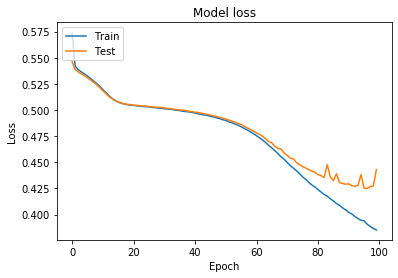

In [69]:
import matplotlib.pyplot as plt
# Plot training & validation accuracy values
plt.plot(pred.history['acc'])
plt.plot(pred.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('training & validation accuracyFinalFinal.pdf')
plt.show()


# Plot training & validation loss values
plt.plot(pred.history['loss'])
plt.plot(pred.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('training & validation lossFinalFinal.pdf')
plt.show()


In [19]:
from gensim.models import Word2Vec
from sklearn import preprocessing
#lab_enc = preprocessing.LabelEncoder()
#lab_enc.fit(data['Sentiment'])
#data = data
tokenized_data = data['text'].apply(lambda x: x.split())
model_w2v = Word2Vec( tokenized_data, size=200, window=5, min_count=2,sg = 1, hs = 0, negative = 10, workers= 2, seed = 34)
model_w2v.train(tokenized_data, total_examples= len(data['text']), epochs=20)
def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vec += model_w2v[word].reshape((1, size))
            count += 1.
        except KeyError:
            continue
    if count != 0:
        vec /= count
        return vec
wordvec_arrays = np.zeros((len(tokenized_data), 200))
for i in range(len(tokenized_data)):
    wordvec_arrays[i,:] = word_vector(tokenized_data[i], 200)
data_feature_3 = pd.DataFrame(wordvec_arrays)
df_tex = data_feature_3
df_cat = data['airline_sentiment']
x_train, x_test, y_train, y_test = train_test_split(df_tex, df_cat, test_size=0.3, random_state=2, stratify=df_cat)
y_train = y_train.astype('int')


C:\Users\Muhammad Umer\Anaconda3\lib\site-packages\ipykernel\__main__.py:14: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,classification_report
lr=LogisticRegression()
predRfc=lr.fit(x_train, y_train).predict(x_test)
print(accuracy_score(y_test,predRfc))
print(classification_report(y_test,predRfc))

C:\Users\Muhammad Umer\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Muhammad Umer\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.7688979963570127
              precision    recall  f1-score   support

           0       0.80      0.93      0.86      2753
           1       0.66      0.45      0.53       930
           2       0.71      0.58      0.64       709

    accuracy                           0.77      4392
   macro avg       0.72      0.65      0.68      4392
weighted avg       0.76      0.77      0.75      4392

